# Characterize the population of remnant black holes

In [303]:
import numpy as np
import numpy.lib.recfunctions
import h5py
import json
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.interpolate import interp1d
import matplotlib 
matplotlib.rcParams['text.usetex'] = True
%config InlineBackend.figure_format='retina'
from scipy.stats import gaussian_kde
import gwpopulation as gwp
import surfinBH
from multiprocessing import Pool
import matplotlib.transforms as mtransforms
import collections.abc
import copy

### Define population model samplers

In [3]:
class ModelB:
    def __init__(self,alpha_m=2,beta_q=1,log10_rate=1e2,m_max=50,m_min=5):
        self.hyperparam_names = ['alpha_m', 'beta_q', 'log10_rate', 'm_max', 'm_min']
        self.alpha_m = alpha_m
        self.beta_q = beta_q
        self.log10_rate = log10_rate
        self.m_max = m_max
        self.m_min = m_min     
        
    def set_hyperparams(self,hyperparams):
        self.alpha_m, self.beta_q,self.log10_rate,self.m_max,self.m_min = hyperparams
        
    def pdf(self,params):
        params = m1,m2
        k = (1.-self.alpha_m) / (self.m_max**(1.-self.alpha_m)-self.m_min**(1.-self.alpha_m))
        Cm1 = (self.beta_q+1.) / (m1**(self.beta_q+1.) - self.m_min**(self.beta_q+1.))
        return k * Cm1 * m1**(-self.alpha_m) * m2**self.beta_q
    
    def inv_cdf_m1(self,CDF):
        return ((self.m_max**(1.-self.alpha_m) - self.m_min**(1.-self.alpha_m))*CDF + self.m_min**(1.-self.alpha_m))**(1./(1.-self.alpha_m))
        
    def inv_cdf_q(self,CDF):
        return CDF**(1./(self.beta_q+1.))
    
    def sample(self,n=1):
        """return m1 and q samples using inverse CDF sampling"""
        return self.inv_cdf_m1(np.random.uniform(size=n)),self.inv_cdf_q(np.random.uniform(size=n))

    


### Define Final State Mapping

In [57]:
sxa1 = 0.187
sya1 = 0.028
sz0 = 0.686
sza1 = 0.15
w = 0.05
k = 0.008
c1 = 0.762
c3 = 0.632
m0 = 0.9515
ma1 = -0.013


def g(q,c):
    return ((c+1.)**2)/((c+q)**2)

def eta(q): return q/((1.+q)**2)

def m_final_frac(s1,s2,q):
    return 1. + (m0 - 1.)*4.*eta(q) + (ma1*16.*eta(q)**2)*(s1[:,2]+s2[:,2])


def g(q,c):
    return ((c+1.)**2)/((c+q)**2)

def eta(q): return q/((1.+q)**2)

def sx_final(s1,s2,q):
    return (
        sxa1 * (g(q,c1)*s1[:,0] + g(1./q,c1)*s2[:,0]) -
        sya1*4.*eta(q)*(s1[:,1]+s2[:,1])
    )

def sy_final(s1,s2,q):
    return (
        sya1*4.*eta(q)*(s1[:,0]+s2[:,0]) +
        sxa1*(g(q,c1)*s1[:,1] + g(1./q,c1)*s2[:,1])
    )

def sz_final(s1,s2,q):
    term1 = sz0 * (4*w*eta(q) + 16.*(1.-w)*eta(q)**2)
    term2 = sza1*(g(q,c3)*s1[:,2] + g(1./q,c3)*s2[:,2])
    term3 = (
        (16.*k*eta(q)**2) *
        ((s1[:,0]+s2[:,0])**2 + (s1[:,1]+s2[:,1])**2 - (s1[:,2]+s2[:,2])**2)
    )
    return term1 + term2 + term3

def s_final(s1,s2,q):
    """
    Compute the final black hole spin from two merging blakc holes with
    spins s1 and s1 (each with x,y,z components) and mass ratio q.  Here,
    equations 5, 6, 8, and 9 from Tichy and Marronetti (2008) [0807.2985]
    are used.

    Parameters
    ----------
    s1: array, shape = (nmergers,3)
        ndarray with 3d spins for each m1 BH
    s2: array, shape = (nmergers,3)
        ndarray with 3d spins for each m2 BH
    q: array
        mass ratios

    Returns
    -------
    s_final: float
        The final BH spin
    """
    return np.array([
        sx_final(s1,s2,q),
        sy_final(s1,s2,q),
        sz_final(s1,s2,q),
    ]).T

def spin_mags(spins):
    return np.sqrt(np.sum(np.square(spins),axis=1))

def compute_delta_m(qs):
    return (1./qs - 1.)/(1./qs + 1.)

def compute_S_tilde_perp(St1x,St1y,St2x,St2y):
    return(np.sqrt((St1x+St2x)**2 + (St1y+St2y)**2))

def compute_S_tilde_par(St1z,St2z):
    return St1z+St2z

def compute_Delta_tilde_par(qs,St1z,St2z):
    return (1./qs + 1.)*St2z - (1. + qs)*St1z

def compute_Delta_tilde_perp(qs, St1x,St1y,St2x,St2y):
    return np.sqrt(((1./qs + 1.)*St2x - (1. + qs)*St1x)**2 +
                   ((1./qs + 1.)*St2y - (1. + qs)*St1y)**2
                  )

# zlochower fitting constants
c1_zl = -0.757
c8_zl = -2100.
c16_zl = -880.
c19_zl = 4200.

def compute_Vh(qs,delta_m,S_par, Delta_par,Delta_perp):
    eta = (1.-delta_m**2)/4.
    term1 = 3678.*(1.+c1_zl*delta_m**2)
    term2 = 2481*2.*S_par + 1792*(2.*S_par)**2
    term3 = 1507*(2*S_par)**3
    return (4.*eta)**2 * Delta_perp*(term1+term2+term3)

def compute_Vc59(qs,delta_m,S_par,S_perp,Delta_par):
    eta = (1.-delta_m**2)/4.
    term1 = 2160. + 3990.*2.*S_par
    term2 = 2.*S_perp*(c16_zl*delta_m + c19_zl*delta_m*(2*S_par)**2)
    return (4.*eta)**2 * (2.*S_perp*Delta_par)*(term1) + term2

def compute_Vx59_sqrd(Vh,Vc59):
    return Vh**2 + Vc59**2 + 2.*Vh*Vc59*np.cos(59*np.pi/180.)

H = 7367.
H2a = -1.63
H2b = -0.58
H3a = -0.717
H3b = -2.24
H3c = -1.22
H3d = -0.0023
H3e = -1.06
H4a = -0.58
H4b = -0.46
H4c = 0.01
H4d = 1.54
H4e = -4.74
H4f = -0.28
a_ = 2.61
b_ = 1.38
c_ = 0.55
A = 1.2e4 #km/s
B = -0.93

def HealyKick_sqrd(delta_m,Sp,Dp):
    # Sp and Dp short for S_tilde_par and Delta_tilde_par
    eta = (1.-delta_m**2)/4.
    o1 = Dp
    o2 = (H2a*Sp*delta_m +
             H2b*Dp*Sp
         )
    o3 = (H3a*Dp**2 * delta_m +
             H3b*Sp**2*delta_m +
             H3c*Dp*Sp**2 +
             H3d*Dp**3 +
             H3e*Dp*delta_m**2
            )
    o4 = (H4a*Sp*Dp**2*delta_m +
             H4b*Sp**3*delta_m +
             H4c*Sp*delta_m**3 +
             H4d*Dp*Sp*delta_m**2 +
             H4e*Dp*Sp**3 +
             H4f*Sp*Dp**3
            )
    xi = a_ + b_*Sp + c_*delta_m*Dp
    vperp = H*eta**2*(o1+o2+o3+o4)
    vm = -A*eta*delta_m*(1+B*eta)
    return (vm+vperp*np.cos(xi))**2 + vperp**2 * np.sin(xi)**2

def ZlochowerKick(qs,s1x,s1y,s1z,s2x,s2y,s2z):
    """
    compute the kick velocity in km/s(?) using
    Zlochower and Lousto kicks from
    https://arxiv.org/pdf/1503.07536.pdf
    using equations 19-23 and prescription
    V_459.

    Paramters
    ---------
    qs: array of mass ratios <= 1
    s1x, s1y, s1z: arrays of the x, y, and z components
        of the dimensionless spin of the more mass BH.
        z is defined as the direction of orbital angualar momentum
    s2x, s2y, s2z: arrays of the x, y, and z components
        of the dimensionless spin of the less mass BH.
        z is defined as the direction of orbital angualar momentum

    Returns
    -------
    V_459: array of kick velocity magnitudes
    """

    # they use a slightly different convention for dimensionless spins
    # wherein the spins are normalized by *total* mass rather than component mass
    # so we have to change variables first
    St1x,St1y,St1z = s1x/(1.+qs)**2,s1y/(1.+qs)**2 ,s1z/(1.+qs)**2
    St2x,St2y,St2z = s2x/(1.+1./qs)**2,s2y/(1.+1./qs)**2 ,s2z/(1.+1./qs)**2

    # Now compute the variables in their fit from eqns 2-8
    delta_m = compute_delta_m(qs)
    S_perp = compute_S_tilde_perp(St1x,St1y,St2x,St2y)
    S_par = compute_S_tilde_par(St1z,St2z)
    Delta_par = compute_Delta_tilde_par(qs,St1z,St2z)
    Delta_perp = compute_Delta_tilde_perp(qs, St1x,St1y,St2x,St2y)

    # Compute the fits
    Vh = compute_Vh(qs,delta_m,S_par, Delta_par,Delta_perp)
    Vc59 = compute_Vc59(qs,delta_m,S_par,S_perp,Delta_par)
    return np.sqrt(compute_Vx59_sqrd(Vh,Vc59) + HealyKick_sqrd(delta_m,S_par,Delta_par))

### Get population predictive distributions
for each hyperposterior sample, draw a few (m1, q) samples based on the hyperposterior sample

In [4]:
model_name = 'model_b'
model = ModelB()
samples_per_hypsample = 10
with h5py.File('figure_data/corner_AB.h5') as f:
    hyperparams = []
    dtype = []
    for hyperparam_name in model.hyperparam_names:
        hyperparams.append(f[model_name][hyperparam_name][...])
        dtype.append((hyperparam_name,float))
    hyperparams = np.array(list(zip(*hyperparams)),dtype=dtype)
    m1q_out = np.empty((2,samples_per_hypsample*len(hyperparams)),dtype=float)
    for hi,hyp in enumerate(hyperparams):
        model.set_hyperparams(hyp)
        lidx = hi*samples_per_hypsample
        uidx = hi*samples_per_hypsample+samples_per_hypsample
        m1q_out[:,lidx:uidx] = model.sample(samples_per_hypsample)


/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


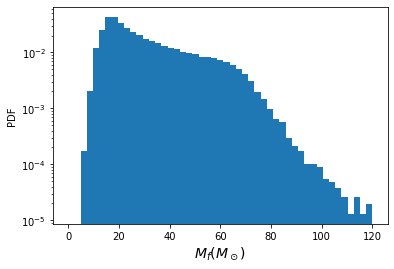

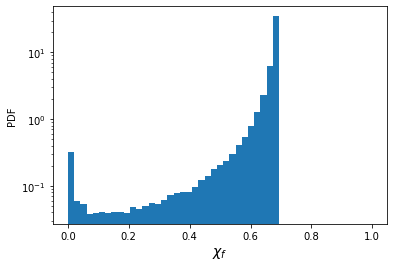

In [43]:
mtot = (1.+m1q_out[1])*m1q_out[0]
s1,s2 = np.zeros((len(mtot),3),dtype=float),np.zeros((len(mtot),3),dtype=float)
mf = mtot*m_final_frac(s1,s2,m1q_out[1])
s_fin = spin_mags(s_final(s1,s2,m1q_out[1]))
plt.hist(mf,bins=np.linspace(0,120,50),density=True);
plt.xlabel(r'$M_f (M_\odot)$',fontsize=14)
plt.ylabel('PDF')
plt.yscale('log')
plt.figure()
plt.hist(s_fin,np.linspace(0,1,50),density=True)
plt.xlabel(r'$\chi_f$',fontsize=14)
plt.ylabel('PDF')
plt.yscale('log')


### Now integrate the rate over time. 
We'll assume the rate follows the cosmic star formation rate, but with some fiducial delay time distribution.  We'll use the star formation rate from [Madau and Fragos](https://arxiv.org/pdf/1606.07887.pdf):
$$\psi(z) = 0.01 \frac{(1+z)^{2.6}}{1+[(1+z)/3.2]^{6.2}} \textrm{M}_\odot \textrm{yr}^{-1}\textrm{Mpc}^{-3}$$
For the delay time distribution, we'll assume:
$$p(t_d) \propto t_d^{-1}\ \textrm{if}\ t_d>10\ \textrm{Myr, else}\ 0$$
The merger rate over cosmic time is:
$$R(t) = A \int_0^{t} p(t-t')\psi(t') dt'$$
And we know that $R(t_h) = R_0$ where $R_0$ is the present-day rate inferred by the LVC, so:
$$A = \frac{R_0}{\int_0^{t_h} p(t-t')\psi(t') dt'}$$
The current number density of remnants is:
$$n = \int_0^{t_h} R(t) dt = R_0\frac{\int_0^{t_h} \int_0^{t} p(t-t')\psi(t') dt'}{\int_0^{t_h} p(t-t')\psi(t') dt'}$$

In [142]:
class RateCalculator(FlatLambdaCDM):
    def __init__(self,H0=70., Om0=0.3,alpha=1,td_min=1e7):
        self.dist_unit = u.megaparsec
        self.time_unit = u.year
        self.alpha= alpha
        self.td_min = td_min #minimum delay time
        super().__init__(H0,Om0)
        self.z_min,self.z_max = 0.0001,15
        #self.zgrid = np.linspace(self.z_min,self.z_max,2000)
        self.zgrid = np.logspace(np.log10(self.z_min),np.log10(self.z_max),5000)
        self.t_of_zgrid = self.hubble_time.to_value(self.time_unit) - self.lookback_time(self.zgrid).to_value(self.time_unit)
        self.t_min = np.amin(self.t_of_zgrid) # age of universe at z_max
        self.t_of_z = interp1d(self.zgrid,self.t_of_zgrid)
        self.z_of_t = interp1d(self.t_of_zgrid,self.zgrid)
        self.R_norm = self.R_of_t(self.hubble_time.to_value(self.time_unit))
        
        
    def sfr_of_t(self,t):
        """Return star formation rate in units of solar masses per year per cubic Mpc"""
        z = self.z_of_t(t) 
        return self.sfr_of_z(z)
        
    def sfr_of_z(self,z):
        return 0.01*(1.+z)**2.6 / (1.+((1.+z)/3.2)**6.2)

    def p_delay_time(self,t):
        """un-normalized probability of a given delay time for a 
        delay time distribution t_d^-alpha where t_d > t_min, else 0
        """
        return np.array([ti**(-self.alpha) if ti>self.td_min else 0 for ti in t])
    
    def R_of_t(self,t):
        sel = self.t_of_zgrid <= t
        # negative sign below to deal with t_of_zgrid going from high to low
        return -np.trapz(self.sfr_of_t(self.t_of_zgrid[sel])*self.p_delay_time(t-self.t_of_zgrid[sel]),self.t_of_zgrid[sel])
    
    def number_density(self,t=None,present_rate=1e-7):
        if t is None:
            t = self.hubble_time.to_value(self.time_unit)
        integrand_vals = np.array(list(map(self.R_of_t,self.t_of_zgrid)))
        sel = self.t_of_zgrid <= t
        return -present_rate*np.trapz(integrand_vals[sel],self.t_of_zgrid[sel])/self.R_norm
        

In [143]:
rate_calc = RateCalculator()
number_density = rate_calc.number_density()
print(f'the current number density of remnant black holes is {number_density} per cubic megaparsec')

the current number density of remnant black holes is 2783.8063759934735 per cubic megaparsec


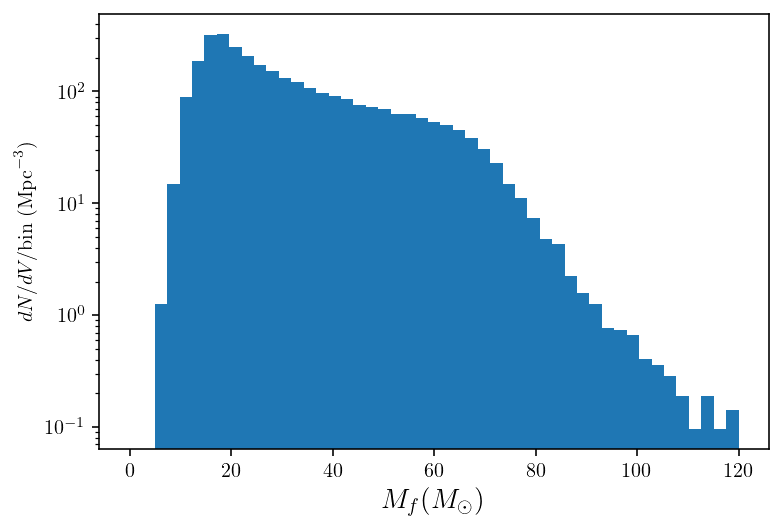

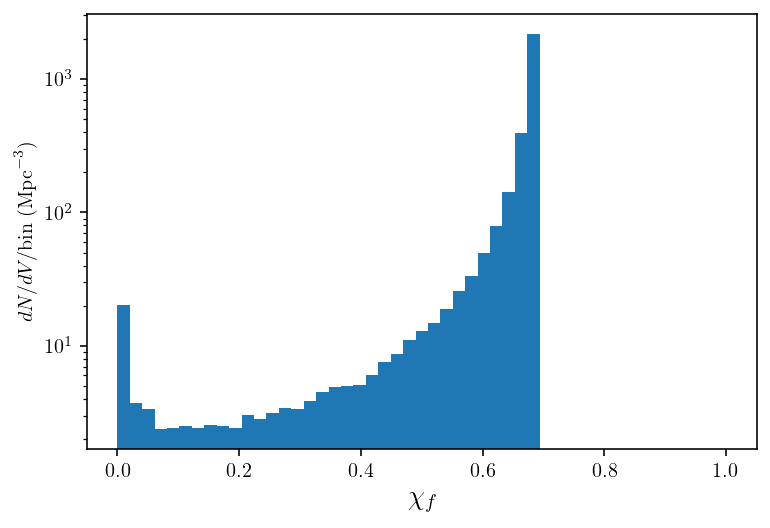

In [55]:
weights = number_density*np.ones_like(mf)/len(mf)
plt.hist(mf,bins=np.linspace(0,120,50),weights = weights);
plt.xlabel(r'$M_f (M_\odot)$',fontsize=14)
plt.ylabel(r'$dN/dV/ \textrm{bin}\ (\textrm{Mpc}^{-3})$')
plt.yscale('log')
plt.figure()
plt.hist(s_fin,np.linspace(0,1,50),weights=weights)
plt.xlabel(r'$\chi_f$',fontsize=14)
plt.ylabel(r'$dN/dV/ \textrm{bin}\ (\textrm{Mpc}^{-3})$')
plt.yscale('log')

### Incorporate the overall rate from the samples
In the above, I entered a fiducial present day rate of $1\times10^{-7}\ \textrm{yr}^{-1}\ \textrm{Mpc}^{-3}$.  Let's now fully self consistently draw a prior curve for every hyperparameter sample:

In [70]:
model_name = 'model_b'
model = ModelB()
use_n_hypersamples = 200
samples_per_hypsample = 1000

#fig,ax = plt.subplots(1,2)
mgrid = np.linspace(0,120,100)
chigrid = np.linspace(0,1,100)
vgrid = np.linspace(0,1000,100)

In [71]:
class ReflectingKde:
    def __init__(self,xtrain,xlow=None,xhigh=None):
        self.xtrain = xtrain
        self.xlow = xlow
        self.xhigh = xhigh
        self.underlying_kde = gaussian_kde(xtrain)
        
    def __call__(self,xeval):
        res = self.underlying_kde(xeval)
        if self.xlow is not None:
            res = res + self.underlying_kde(2.*self.xlow - xeval)
        if (self.xhigh is not None) and (self.xlow is not None):
            res = res + self.underlying_kde(self.xhigh + (xeval - self.xlow)[::-1])
        elif (self.xhigh is not None) and (self.xlow is None):
            res = res + self.underlying_kde(self.xhigh + xeval[::-1])
        return res

def get_mf_sf_pdf(hyp):
    model = ModelB(*hyp)
    num_dens = rate_calc.number_density(present_rate=10**hyp['log10_rate']*1e-9)
    m1samp, qsamp = model.sample(samples_per_hypsample)
    mtot = (1.+qsamp)*m1samp
    s1,s2 = np.zeros((len(mtot),3),dtype=float),np.zeros((len(mtot),3),dtype=float)
    mf = mtot*m_final_frac(s1,s2,qsamp)
    s_fin = spin_mags(s_final(s1,s2,qsamp))
    v_kick = ZlochowerKick(qsamp,0,0,0,0,0,0)
    p_mf = num_dens*ReflectingKde(mf)(mgrid)
    p_sf = num_dens*ReflectingKde(s_fin,xlow=0,xhigh=1)(chigrid)
    p_vkick = num_dens*ReflectingKde(v_kick,xlow=0)(vgrid)
    return p_mf,p_sf,p_vkick
    

In [72]:
with h5py.File('figure_data/corner_AB.h5') as f:
    hyperparams = []
    dtype = []
    for hyperparam_name in model.hyperparam_names:
        hyperparams.append(f[model_name][hyperparam_name][...])
        dtype.append((hyperparam_name,float))
    hyperparams = np.array(list(zip(*hyperparams)),dtype=dtype)
    hyperparams = np.random.choice(hyperparams,size=use_n_hypersamples,replace=False)
    from multiprocessing import Pool
    with Pool(8) as p:
        out = np.array(p.map(get_mf_sf_pdf,hyperparams))
    #out = np.array([get_mf_sf_pdf(hyp) for hyp in hyperparams])
    np.save('Mf_sf_pdfs.npy',out) 

the number density of remnant black holes today is 1537.6942055875484 per cubic megaparsec
the number density of remnant black holes today is 1631.592344222557 per cubic megaparsec
the number density of remnant black holes today is 1546.0672418914437 per cubic megaparsec


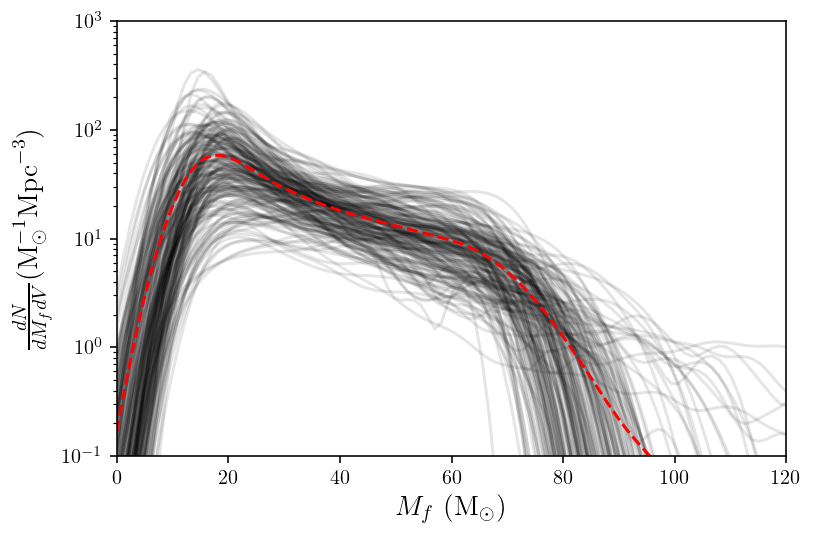

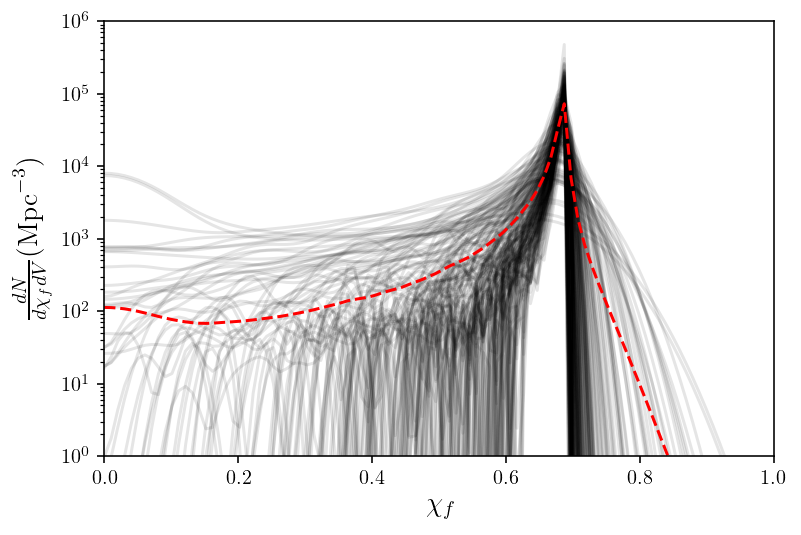

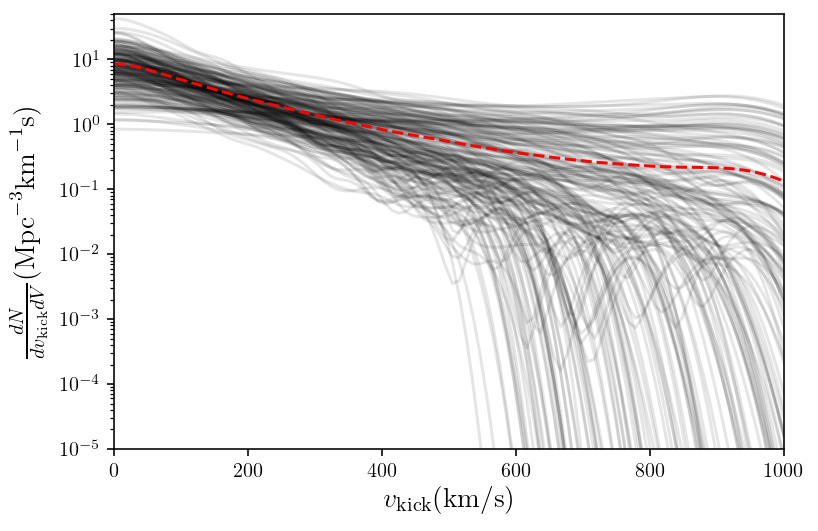

In [82]:
data = np.load('Mf_sf_pdfs.npy')
plt.plot(mgrid,data[:,0,:].T,alpha=0.1,color='k')
plt.plot(mgrid,(data[:,0,:].T).mean(axis=1),color='r',ls='--')
n = np.trapz((data[:,0,:].T).mean(axis=1),mgrid)
print(f'the number density of remnant black holes today is {n} per cubic megaparsec')
plt.ylim(1e-1,1e3)
plt.yscale('log')
plt.xlim([0,120])
plt.xlabel(r'$M_f\ (\textrm{M}_\odot)$',fontsize=14)
plt.ylabel(r'$\frac{dN}{dM_f dV} (\textrm{M}_\odot^{-1}\textrm{Mpc}^{-3})$',fontsize=14)
plt.savefig('Mf_number_density.png',dpi=300)

plt.figure()
plt.plot(chigrid,data[:,1,:].T,alpha=0.1,color='k')
plt.plot(chigrid,(data[:,1,:].T).mean(axis=1),color='r',ls='--')
n = np.trapz((data[:,1,:].T).mean(axis=1),chigrid)
print(f'the number density of remnant black holes today is {n} per cubic megaparsec')

#plt.ylim(1e-1,1e3)
plt.yscale('log')
plt.ylim([1e0,1e6])
plt.xlim([0,1])
plt.xlabel(r'$\chi_f$',fontsize=14)
plt.ylabel(r'$\frac{dN}{d\chi_f dV} (\textrm{Mpc}^{-3})$',fontsize=14)
plt.savefig('chif_number_density.png',dpi=300)

plt.figure()
plt.plot(vgrid,data[:,2,:].T,alpha=0.1,color='k')
plt.plot(vgrid,(data[:,2,:].T).mean(axis=1),color='r',ls='--')
n = np.trapz((data[:,2,:].T).mean(axis=1),vgrid)
print(f'the number density of remnant black holes today is {n} per cubic megaparsec')

#plt.ylim(1e-1,1e3)
plt.yscale('log')
plt.ylim(1e-5,50)
plt.xlim([0,1000])
plt.xlabel(r'$v_{\rm kick} (\textrm{km}/\textrm{s})$',fontsize=14)
plt.ylabel(r'$\frac{dN}{dv_{\rm kick} dV} (\textrm{Mpc}^{-3} \textrm{km}^{-1} \textrm{s})$',fontsize=14)
plt.savefig('vf_number_density.png',dpi=300)

## Re-vamp with O3a 
Here we're going to use the latest and greatest from O3a results.  The power-law + peak model had the highest BF in the O3a populations paper, so that's the one we'll use for this analysis.  The tricky part is pulling individual merger samples for each hyperparameter sample.  We'll do that using a mix of reverse CDF sampling and rejection sampling

In [112]:
# Get population hyperparameter samples for the power law + peak samples
# Load Power Law + Peak samples
with open("Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples = jf['posterior']['content']
    
# add in the mean and variance of the spin mag beta distribution converted to alpha and beta:
mu = np.array(posterior_samples['mu_chi'])
sigma_sqrd = np.array(posterior_samples['sigma_chi']) # this is mislabeled in the file as sigma instead of variance
posterior_samples['alpha_chi'] = ((1. - mu) / sigma - 1. /mu ) * (mu ** 2.)
posterior_samples['beta_chi'] = posterior_samples['alpha_chi']*(1.-mu)/mu

In [145]:
np.median(posterior_samples['log_10_rate'])

1.3786881946070975

Set up the grids which will be sampled based on population weighting

In [176]:
mass_dist_params = ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m']
spinmag_dist_params = ['alpha_chi', 'beta_chi']
spintilt_params = ['xi_spin', 'sigma_spin']
hyp_name_dict = {'mass':mass_dist_params,
               'spinmag':spinmag_dist_params,
               'spintilt':spintilt_params
              }

masspop = gwp.models.mass.SinglePeakSmoothedMassDistribution()
spinmagpop = gwp.models.spin.iid_spin_magnitude_beta #(dataset, xi_spin, sigma_spin, amax, alpha_chi, beta_chi)
spintiltpop = gwp.models.spin.iid_spin_orientation_gaussian_isotropic
pops = {'mass':masspop,'spinmag':spinmagpop,'spintilt':spintiltpop}

# set up mass grid 
m1s_grid = np.linspace(3,100,400)
qs_grid = np.linspace(0.01,1,100)
M1s,Qs = np.meshgrid(m1s_grid,qs_grid)
mass_pts = np.array(list(zip(M1s.flatten(),Qs.flatten())),dtype=[('mass_1',float),('mass_ratio',float)])

# set up spin mag grid
as_grid = np.linspace(0,1,100)
A1s,A2s = np.meshgrid(as_grid,as_grid)
as_pts = np.array(list(zip(A1s.flatten(),A2s.flatten())),dtype=[('a_1',float),('a_2',float)])

# set up spin tilt grid
costilts_grid = np.linspace(-1,1,100)
Ctilts1,Ctilts2 = np.meshgrid(costilts_grid,costilts_grid)
costilts_pts = np.array(list(zip(Ctilts1.flatten(),Ctilts2.flatten())),dtype=[('cos_tilt_1',float),('cos_tilt_2',float)])

grids = {'mass':mass_pts,'spinmag':as_pts,'spintilt':costilts_pts}

def get_event_samples(hypersample,n_samples=1000):
    sample_arr = []
    for hypname in pops.keys():
        hyp_dict = {param:hypersample[param] for param in hyp_name_dict[hypname]}
        ps = pops[hypname](grids[hypname],**hyp_dict)
        samples = np.random.choice(grids[hypname],size=n_samples,replace=True,p=ps/np.sum(ps))
        sample_arr.append(samples)
    return np.lib.recfunctions.merge_arrays(sample_arr,flatten=True,usemask=False)
    
def mag_tilt_to_components(a,cos_tilt):
    phase = np.random.uniform(2*np.pi)
    sin_tilt = np.sqrt(1.-cos_tilt**2)
    return [
        a*sin_tilt*np.cos(phase), #x
        a*sin_tilt*np.sin(phase), #y
        a*cos_tilt #z
    ]    

def get_weights(hypersample,event_samples):
    ps_arr = []
    for hypname in pops.keys():
        hyp_dict = {param:hypersample[param] for param in hyp_name_dict[hypname]}
        ps_arr.append(pops[hypname](event_samples,**hyp_dict))
    return np.multiply.reduce(ps_arr)

Get mass and spin samples from the maxL population

In [177]:
n_event_samples = 20000
max_L_idx = np.argmax(posterior_samples['log_likelihood'])
fid_pop_samples = get_event_samples({key:value[max_L_idx] for key,value in posterior_samples.items()},
                                    n_samples=n_event_samples)

/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:434: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/utils.py:11: RuntimeWarning: divide by zero encountered in log
  ln_beta = (alpha - 1) * xp.log(xx) + (beta - 1) * xp.log(scale - xx)


Now use SurfinBH to get the final masses and spins

In [178]:
fit_name = 'NRSur7dq4Remnant'
fit = surfinBH.LoadFits(fit_name)

def calc_final_state(samples):
    q = 1./samples['mass_ratio'] # use q>=1 definition
    chi_1 = mag_tilt_to_components(samples['a_1'],samples['cos_tilt_1'])
    chi_2 = mag_tilt_to_components(samples['a_2'],samples['cos_tilt_2'])
    mf, chif, vf, _, _, _ = fit.all(q, chi_1, chi_2,allow_extrap=True,**{'estimate_err':False})
    return mf*samples['mass_1']*(1.+1./q),np.linalg.norm(chif),np.linalg.norm(vf)

Loaded NRSur7dq4Remnant fit.


In [179]:
pool = Pool(4)
final_params = np.array(pool.map(calc_final_state,fid_pop_samples))
np.save('final_params.npy',final_params)

In [ ]:
final_params = np.load('final_params.npy')

In [269]:
def weighted_percentile(a,w,q):
    """
    a: array of samples
    w: weights of samples
    q: percentiles
    """
    w=w/np.sum(w)
    sorta = np.array([s for s,_ in sorted(zip(a,w))])
    sortw = np.array([wt for _,wt in sorted(zip(a,w))])
    if isinstance(q,collections.abc.Iterable):
        return np.array([sorta[np.cumsum(sortw)>(qi/100.)][0] for qi in q])
    else:
        return sorta[np.cumsum(sortw)>(q/100.)][0]

n_grid_pts = 100 
mass_plot_grid = np.linspace(6,200,n_grid_pts)
chif_plot_grid = np.linspace(0,1,n_grid_pts)
vf_plot_grid = np.linspace(0,4,n_grid_pts)
#scales = [1.,1.,3e5]
transforms = [lambda x:x, lambda x:x, lambda x:(np.log10(3e5*x))]
plot_grids = [mass_plot_grid,chif_plot_grid,vf_plot_grid]
xlabels = ['M_f','\chi_f','v_f']

base_rate = rate_calc.number_density(present_rate=1.)

fid_weights = get_weights({key:value[max_L_idx] for key,value in posterior_samples.items()},fid_pop_samples)

n_hyper_lines = 500 
n_params = len(xlabels)
percentiles = [1,50,99]
pctl_array = np.empty((len(percentiles),n_hyper_lines,n_params))
lines = np.empty([n_grid_pts,n_hyper_lines,n_params])
rates = []
hyp_idx = []
wts_arr = []
for i,k in enumerate(np.random.choice(len(posterior_samples['alpha']),size=n_hyper_lines,replace=False)):
    hyp_idx.append(k)
    wts = get_weights({key:value[i] for key,value in posterior_samples.items()},fid_pop_samples)/fid_weights ;
    wts[np.isnan(wts) | np.isinf(wts)] = 0.
    wts = wts/np.sum(wts)
    wts_arr.append(wts)
    rate = base_rate*(10.**posterior_samples['log_10_rate'][i])*1e-9 #1e-9 to convert to Mpc^3
    rates.append(rate)
    for j in range(len(ax)):
        pctl_array[:,i,j] = weighted_percentile(transforms[j](final_params[:,j]),wts,q=percentiles)
        lines[:,i,j] = rate*gaussian_kde(transforms[j](final_params[:,j]),weights=wts)(plot_grids[j])

hyp_idx = np.array(hyp_idx)
wts_arr = np.array(wts_arr)
        
rates = np.array(rates)
m_rate,l_rate,u_rate = np.median(rates),np.percentile(rates,5),np.percentile(rates,95)
rates_mwev = rates*10. # 0.1 galaxy per cubic megaparsec -> 10 cubic megaparsecs per galaxy
m_rate_mwev,l_rate_mwev,u_rate_mwev = np.median(rates_mwev),np.percentile(rates_mwev,5),np.percentile(rates_mwev,95)

/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:434: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:370: RuntimeWarning: invalid value encountered in true_divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)


In [242]:
print(f'the number density of remnant black holes is {m_rate:2.1f} (-{m_rate-l_rate:2.1f}/+{u_rate-m_rate:2.1f}) per cubic Mpc')
print(f'the number density of remnant black holes is {m_rate_mwev:2.1f} (-{m_rate_mwev-l_rate_mwev:2.1f}/+{u_rate_mwev-m_rate_mwev:2.1f}) per MW ev galaxy')


the number density of remnant black holes is 649.8 (-289.1/+570.5) per cubic Mpc
the number density of remnant black holes is 6498.1 (-2891.4/+5704.9) per MW ev galaxy


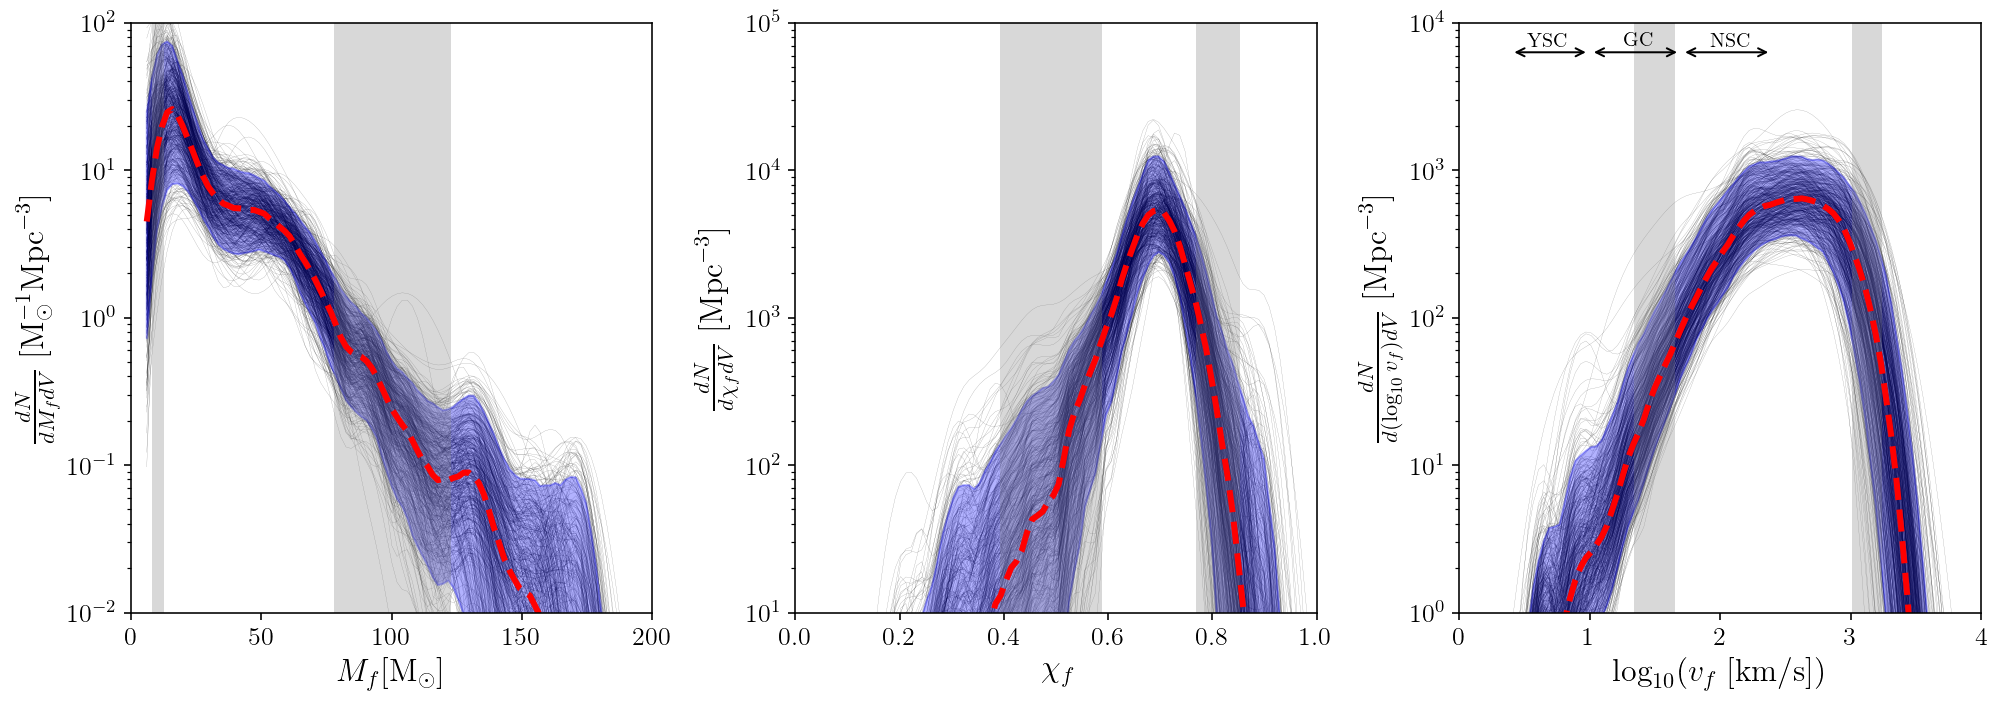

In [320]:
units = ['[\mathrm{{M}}_{{\odot}}]','','\;[\mathrm{km/s}]']
yunits = ['\;[\mathrm{{M}}_\odot^{{-1}}\mathrm{{Mpc}}^{{-3}}]','\;[\mathrm{{Mpc}}^{{-3}}]','\;[\mathrm{{Mpc}}^{{-3}}]']
logunits = [False,False,True]
xlims = [(0,200),(0,1),(0,4)]
ylims = [(1e-2,1e2),(1e1,1e5),(1e0,1e4)]
xlabels = ['M_f','\chi_f','v_f']

fig,ax = plt.subplots(1,3,figsize=(14,5))
for j in range(len(ax)):
    ax[j].tick_params(labelsize=13)
    paramlines = lines[:,:,j]
        
    # plot the individual population lines
    for i in range(lines.shape[1]):
        ax[j].plot(plot_grids[j],paramlines[:,i],color='k',alpha=0.5,zorder=0,lw=0.1)
    
    # plot the credible region and median
    ax[j].fill_between(plot_grids[j],np.percentile(paramlines,5,axis=1),np.percentile(paramlines,95,axis=1),color='b',alpha=0.3)
    ax[j].plot(plot_grids[j],np.median(paramlines,axis=1),color='r',linestyle='--',lw=3)
    ax[j].set_ylim(ylims[j])
    ax[j].set_xlim(xlims[j])
    ax[j].set_yscale('log')
    
    # If using a pre-logged variable
    if logunits[j]:
        ax[j].set_xlabel(r'$\log_{{10}}({}{})$'.format(xlabels[j],units[j]),fontsize=16)
        ax[j].set_ylabel(r'$\frac{{dN}}{{d(\log_{{10}}{})dV}}{}$'.format(xlabels[j],yunits[j]),fontsize=16)
    else:
        ax[j].set_xlabel(f'${xlabels[j]}{units[j]}$',fontsize=16)
        ax[j].set_ylabel(r'$\frac{{dN}}{{d{}dV}}{}$'.format(xlabels[j],yunits[j]),fontsize=16)
                           
    # plot the percentile credible regions
    trans = mtransforms.blended_transform_factory(ax[j].transData, ax[j].transAxes)
    for k in [0,2]:
        ax[j].fill_between(
            np.array([np.percentile(pctl_array[k,:,j],10),np.percentile(pctl_array[k,:,j],90)]),
            0,1,
            facecolor='gray',alpha=0.3,transform=trans)

ax[2].annotate("", xy=(0.25, 0.95), xytext=(0.39/4, 0.95), arrowprops=dict(arrowstyle="<->"),xycoords='axes fraction')
ax[2].annotate(r"$\mathrm{YSC}$", xy=(0.13, 0.96),xycoords='axes fraction')

ax[2].annotate("", xy=(1.7/4, 0.95), xytext=(0.25, 0.95), arrowprops=dict(arrowstyle="<->"),xycoords='axes fraction')
ax[2].annotate(r"$\mathrm{GC}$", xy=(0.315, 0.96),xycoords='axes fraction')

ax[2].annotate("", xy=(2.4/4, 0.95), xytext=(1.7/4, 0.95), arrowprops=dict(arrowstyle="<->"),xycoords='axes fraction')
ax[2].annotate(r"$\mathrm{NSC}$", xy=(0.48, 0.96),xycoords='axes fraction')


fig.tight_layout()
fig.savefig('final_param_dist.pdf')
fig.savefig('final_param_dist.png',dpi=300)

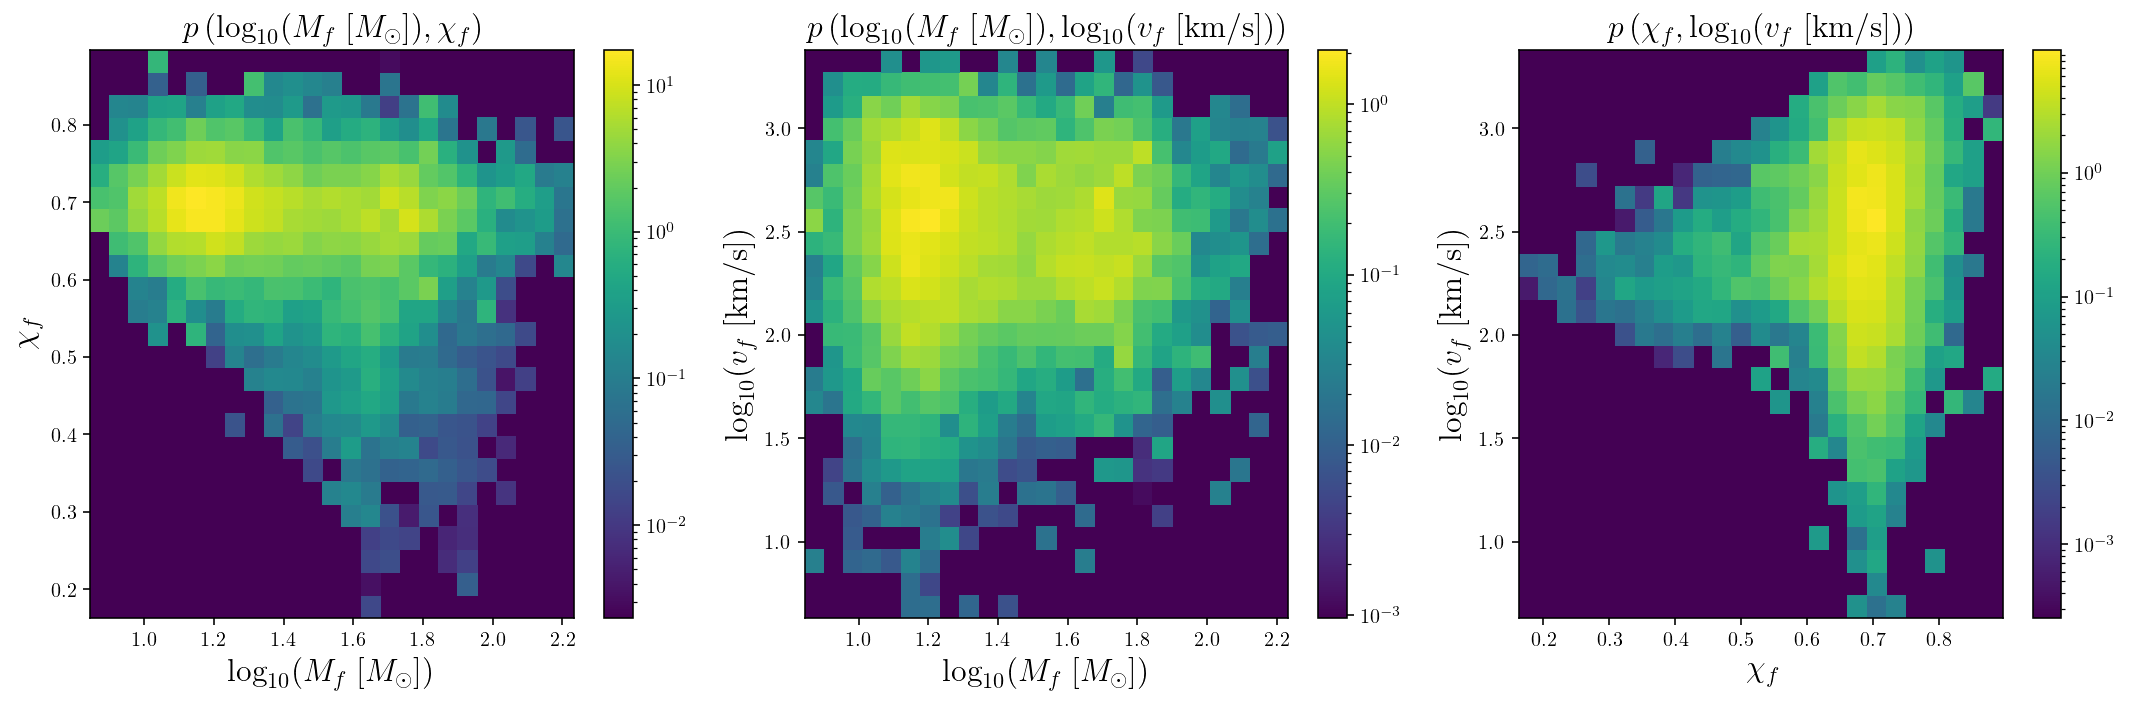

In [334]:
new_wts_arr = np.empty(n_hyper_lines*n_event_samples)
new_fin_params_arr = np.empty((n_hyper_lines*n_event_samples,final_params.shape[1]))
for i in range(n_hyper_lines):
    new_wts_arr[(i*n_event_samples):((i+1)*(n_event_samples))] = wts_arr[i,:]
    new_fin_params_arr[i*n_event_samples:(i+1)*(n_event_samples),:] = final_params

transforms = [lambda x:np.log10(x), lambda x:x, lambda x:(np.log10(3e5*x))]
labels = [r'\log_{10}(M_f\; [M_{\odot}])',r'\chi_f',r'\log_{10}(v_f\; [\mathrm{km/s}])']
names = ['Mf','xf','vf']
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.flatten()
ax_num=0
for j in range(n_params):
    for k in range(n_params):
        if k <= j:
            continue    
        #fig,ax = plt.subplots()
        ax[ax_num].set_facecolor(my_cmap(0))
        im = ax[ax_num].hist2d(transforms[j](new_fin_params_arr[:,j]),transforms[k](new_fin_params_arr[:,k]),
                   weights=new_wts_arr,density=True,bins=25,norm=matplotlib.colors.LogNorm(),cmap=plt.cm.viridis)
        ax[ax_num].set_xlabel(r'$'+labels[j]+r'$',fontsize=16)
        ax[ax_num].set_ylabel(r'$'+labels[k]+r'$',fontsize=16)
        ax[ax_num].set_title(r'$p\left('+labels[j]+','+labels[k]+r'\right)$',fontsize=16)
        fig.colorbar(im[3], ax=ax[ax_num])
        ax_num += 1
fig.tight_layout()
fig.savefig(f'remnant_2d_dist.pdf')
fig.savefig(f'remnant_2d_dist.png',dpi=300)

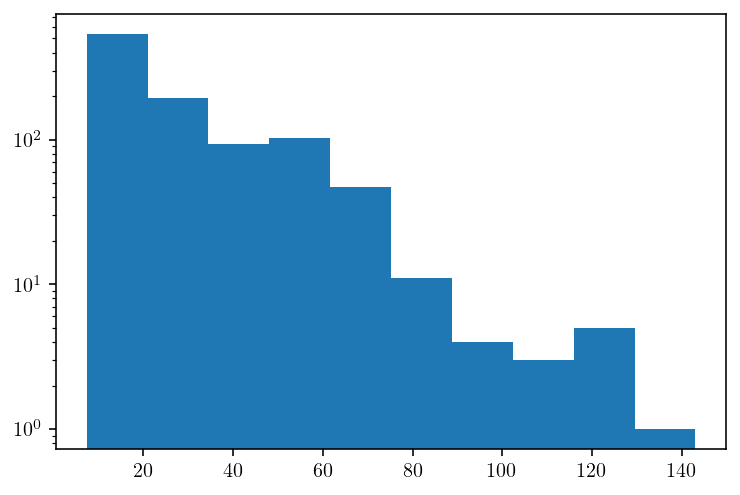

In [75]:
for hypname in pops.keys():
    hyp_dict = {param:hypersample[param] for param in hyp_name_dict[hypname]}
    ps = pops[hypname](grids[hypname],**hyp_dict)
pops[hypname](grids[hypname],**hyp_dict)

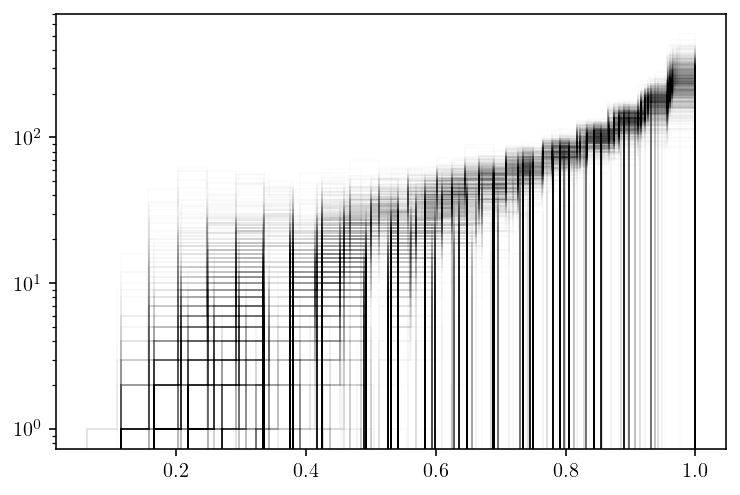

In [11]:
for samples in all_samples:
    plt.hist(samples['mass_ratio'],bins=20,histtype='step',color='k',alpha=0.01)
plt.yscale('log')

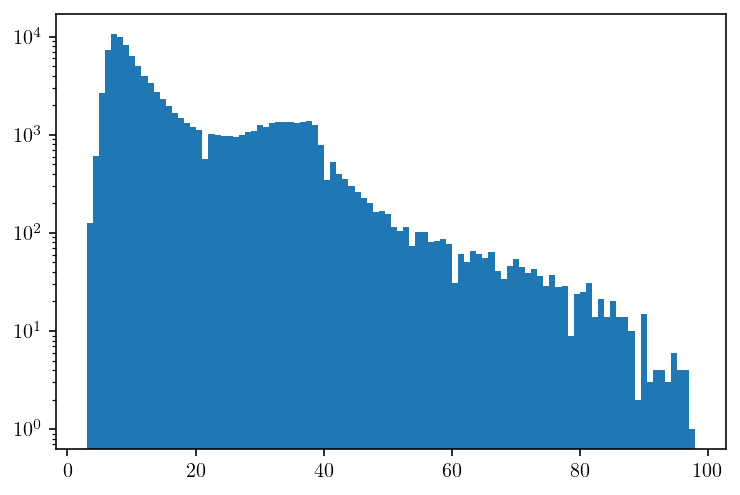

In [8]:
m1_samples = np.array([dataset[indices[i]]['mass_1'] for i in range(indices.shape[0])])
plt.hist(m1_samples.flatten(),bins=100)
plt.yscale('log')

(1e-05, 100000.0)

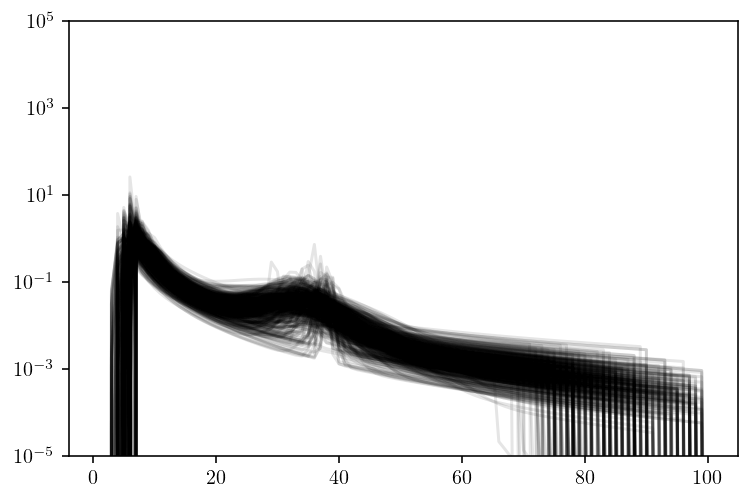

In [43]:
plt.semilogy(m1s,np.array(ps).T,color='k',alpha=0.1);
plt.ylim([1e-5,1e5])

### A quick check that the rate doesn't go too high at higher z:

Text(0, 0.5, '$\\mathcal{R}\\ (\\textrm{Gpc}^{-3}\\ \\textrm{yr}^{-1})$')

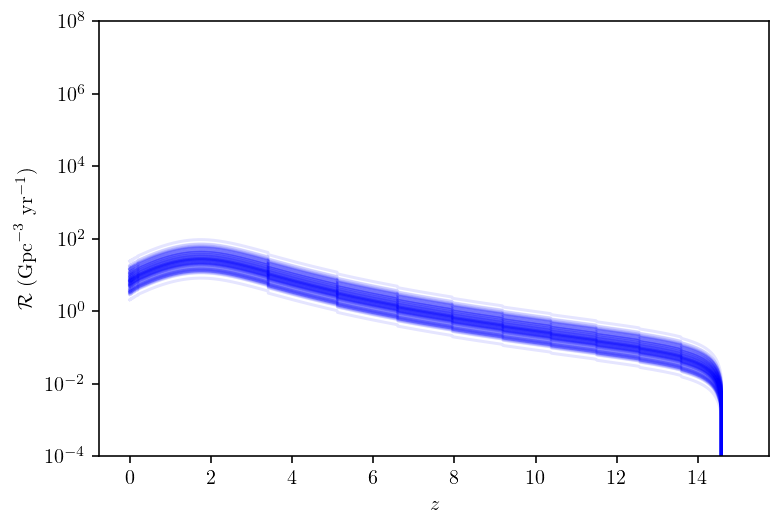

In [35]:
ts = rate_calc.t_of_zgrid
zs = rate_calc.zgrid
Roft = np.array([rate_calc.R_of_t(t) for t in ts])
model_name = 'model_b'
with h5py.File('figure_data/corner_AB.h5') as f:
    log10rates = f[model_name]['log10_rate'][...]
    for i in np.random.choice(range(len(log10rates)),100):
        plt.plot(zs,10**log10rates[i]*Roft,color='b',alpha=0.1)
plt.yscale('log') 
#plt.xlim([0,5])
plt.ylim([1e-4,1e8])
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathcal{R}\ (\textrm{Gpc}^{-3}\ \textrm{yr}^{-1})$')

In [25]:
with h5py.File('figure_data/corner_AB.h5') as f:
    log10rates = f[model_name]['log10_rate'][...]
    print(log10rates)

[1.77793562 1.91705608 1.83690917 ... 1.87884378 1.61471093 1.66236067]


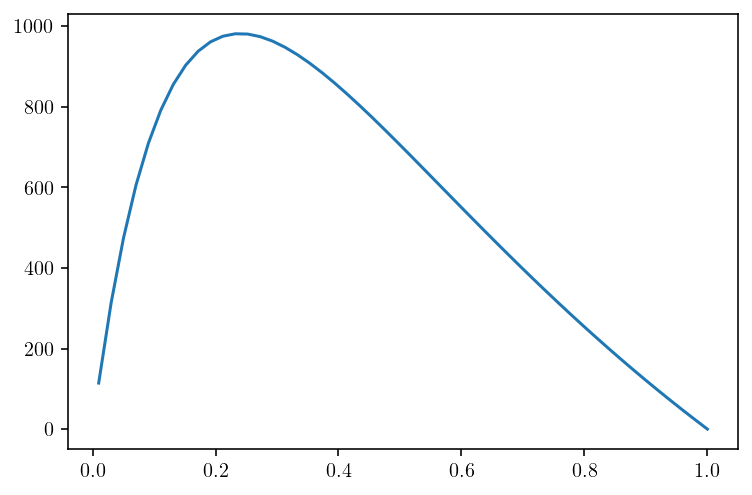

In [84]:
qs = np.linspace(0.01,1,50)
kicks = ZlochowerKick(qs,0,0,0,0,0,0)
plt.plot(qs,kicks)